In this problem we will use the BERT model for sentiment analysis. We will start with a pre-trained BERT model and fine-tune it on a dataset of Google Play store reviews.

## Setup

Install [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
!pip install -q -U watermark

In [24]:
!pip install -qq transformers

In [25]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.5.0


## Data Exploration

Download the Google Play app reviews dataset using the following commands:

In [26]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 80.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.1MB/s]



Here is how it looks like:

In [27]:
import pandas as pd
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Let's first check the size of the dataset. 

In [28]:
# TODO: Q1. How many samples are there in this dataset? 
print(f"Number of columns = {len(df.columns)}")
print(f"Number of rows = {len(df)}")


Number of columns = 11
Number of rows = 15746


Q1: There are 15746 samples in this dataset

In [29]:
# TODO: Q2. Plot a histogram of review scores. These can be accessed in the df.score field in the above dataframe. Which score is the most common?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b3495edd8>]],
      dtype=object)

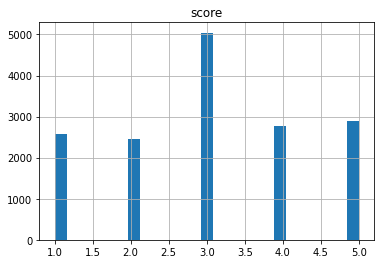

In [30]:
df.hist(column='score', bins= 25)

Q2) Score 3 is the most common score

If correctly plotted, you should be able to see that this is a somewhat imbalanced dataset. Let's first convert the dataset into three classes: negative, neutral, and positive sentiment:

In [31]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [32]:
class_names = ['negative', 'neutral', 'positive']

In [33]:
# TODO: Q3. Plot the histogram of review sentiments, and show that it is now approximately balanced.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b346fbc18>]],
      dtype=object)

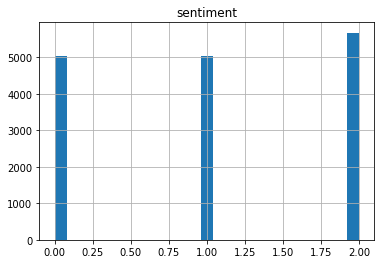

In [34]:
df.hist(column='sentiment', bins= 25)

Q3) Now the categories seem to be balanced


## Data Preprocessing

Let's now load a pre-trained BERT model and the corresponding tokenizer, which converts text data into tokens. 


In [35]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [36]:
from transformers import BertTokenizer

In [37]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's see how tokenization works. Here is the test sentence. Convert into tokens using the `tokenizer.tokenize` and `tokenizer.convert_tokens_to_ids` methods.



In [38]:
sample_txt = 'Every day feels like the same during the lock down.'

In [39]:
# TODO: Q4. Print the tokens and token ids of the sample text above.
print(' Original: ', sample_txt)

print('Tokenized: ', tokenizer.tokenize(sample_txt))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample_txt)))

 Original:  Every day feels like the same during the lock down.
Tokenized:  ['Every', 'day', 'feels', 'like', 'the', 'same', 'during', 'the', 'lock', 'down', '.']
Token IDs:  [4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205, 119]


BERT has special tokens for sentence separators \[SEP\] and unknown words \[UNK\]. This can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method, which takes the test sentence and encodes it into `input_ids`.

In [43]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [20]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205,  119,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Use the `tokenizer.convert_ids_to_tokens` method to invert the encoded token ids (the above tensor of length 32) and visualize the sentence.

In [ ]:
# TODO: Q5. Invert the encoded token ids.
print('Inverted tokens IDs: ', tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

Inverted tokens IDs:  ['[CLS]', 'Every', 'day', 'feels', 'like', 'the', 'same', 'during', 'the', 'lock', 'down', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


Most reviews in the dataset contain less than around 120 tokens, but let us choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

# Building the dataset

Let's now create a dataset using the tokenizer. Here is some code that does this:

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data into 90-5-5 train-validation-test.

In [ ]:
# TODO: Q6. Create three data frames: df_train, df_val, df_train as above and print their shapes.

In [ ]:
df_val, df_train, df_test = np.split(df.sample(frac=1, random_state=42), [int(0.05*len(df)), int(.95*len(df))])
print(len(df_train))
print(len(df_val))
print(len(df_test))

14171
787
788


We also need to create a couple of data loaders:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


Let's now load the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Load the model using:

In [ ]:
from transformers import BertModel
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And encode our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])

The `last_hidden_state` is the sequence of hidden states of the last layer of the model. The `pooled_output` can be thought of as a summary of the content in the test sentence. Try printing out the sizes of `last_hidden_state` and `pooled_output`:

In [ ]:
# TODO: Q7. Print the sizes of the hidden states and the pooled output.

In [ ]:
print(last_hidden_state.shape)

torch.Size([1, 32, 768])


In [ ]:
print(pooled_output.shape)

torch.Size([1, 768])


We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
import torch
import torch.nn as nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
    output = self.drop(pooled_output)
    return self.out(output)

Note that our sentiment classifier takes the BERT backbone and adds a dropout layer (for regularization) and a linear dense layer, which we train using cross-entropy. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
device = torch.device('cuda:0')
# device = torch.device('cpu')
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:







In [ ]:
import torch.nn.functional as F
outputs = F.softmax(model(input_ids, attention_mask), dim=1)
_, preds = torch.max(outputs, dim=1)
print(preds)

tensor([2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2], device='cuda:0')


### Training

To train the model, we will use the AdamW optimizer and a linear learning-rate scheduler with no warmup steps, along with the cross-entropy loss. Five epochs (full passes through the training data should be enough) should be enough, but you can experiment with more epochs.

In [ ]:
EPOCHS = 5
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    # TODO Q8. Complete the incomplete code snippets below to finish training.

    input_ids = d['input_ids']
    attention_mask = d['attention_mask']
    targets = d['targets']

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    targets = targets.to(device)

    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    for t,p in zip(targets, preds):
        if t==p:
            correct_predictions+=1

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

Let's write another function that helps us evaluate the model on a given data loader.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    with torch.no_grad():
      input_ids = d['input_ids']
      attention_mask = d['attention_mask']
      targets = d['targets']

      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      targets = targets.to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      for t,p in zip(targets, preds):
        if t==p:
            correct_predictions+=1
            
      losses.append(loss.item())
  

  # TODO: Q9. Reproduce the above code but only evaluate the model (without any weight updates).

  return correct_predictions / n_examples, np.mean(losses)

Using those two, we can write our training loop.

In [ ]:
%%time

import collections
history = collections.defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # TODO: Q10. Complete the code below to track train and test accuracy.losses

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, total_steps)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(val_data_loader) * EPOCHS)

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.7334405353994994 accuracy 2.1212189616252823
Val   loss 0.5675720101594925 accuracy 2.42

Epoch 2/5
----------
Train loss 0.44952972842964845 accuracy 2.636568848758465
Val   loss 0.5064004972577095 accuracy 2.604

Epoch 3/5
----------
Train loss 0.26525808058513023 accuracy 2.9119638826185104
Val   loss 0.49771677611395715 accuracy 2.696

Epoch 4/5
----------
Train loss 0.1642807944869343 accuracy 3.033634311512415
Val   loss 0.560127753126435 accuracy 2.76

Epoch 5/5
----------
Train loss 0.12052614398637805 accuracy 3.0821670428893904
Val   loss 0.5848646815144457 accuracy 2.772

CPU times: user 22min 37s, sys: 14min 40s, total: 37min 18s
Wall time: 37min 34s


Note that we're storing the best model, indicated by the highest validation accuracy.

Plot train and validation accuracy as a function of epoch count.

In [ ]:
# TODO: Q11. Plot train/validation accuracies.

In [ ]:
def plot(out_dict, epochs):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.plot(range(epochs),out_dict['train_acc'],'-',linewidth=3,label='Train acc')
    plt.plot(range(epochs),out_dict['val_acc'],'-',linewidth=3,label='Val acc')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.grid(True)
    plt.legend()
    plt.show()
    return

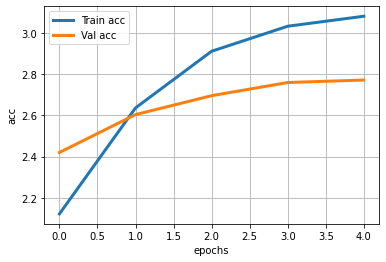

In [ ]:
plot(history, EPOCHS)

You might try to fine-tune the parameters (learning rate, batch size) a bit more if accuracy is not good enough.


## Evaluation

So how good is our model on predicting sentiment?

We'll define a helper function to get the predictions from our model:

In [ ]:
model.load_state_dict(torch.load('/content/best_model_state.bin'))
model.eval()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let us compare true sentiment vs predicted sentiment by plotting a confusion matrix of `y_test` vs `y_pred`.

In [ ]:
# TODO. Q12. Plot the 3x3 confusion matrix and show that the model finds it a bit difficult to classify neutral reviews.

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
print(cm)

[[194  26   4]
 [ 16 230  23]
 [  2  25 268]]


In [ ]:
print(f'Misclassifications for negative reviews = {cm[0][1] + cm[0][2]}')
print(f'Misclassifications for neutral reviews = {cm[1][0] + cm[1][2]}')
print(f'Misclassifications for positive reviews = {cm[2][0]+cm[2][1]}')

Misclassifications for negative reviews = 30
Misclassifications for neutral reviews = 39
Misclassifications for positive reviews = 27


In [ ]:
print(f'Accuracy for negative reviews = {cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])}')
print(f'Accuracy for neutral reviews = {cm[1][1]/(cm[1][0]+cm[1][1]+cm[1][2])}')
print(f'Accuracy for positive reviews = {cm[2][2]/(cm[2][0]+cm[2][1]+cm[2][2])}')

Accuracy for negative reviews = 0.8660714285714286
Accuracy for neutral reviews = 0.8550185873605948
Accuracy for positive reviews = 0.9084745762711864


The above calculations show that the model finds it a bit difficult to classify neutral reviews

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
# TODO: Q13. Print the predicted sentiment in `review_text`.

In [ ]:
review_text = "I love Deep Learning! Best course evah!!!1!!"
encoding = tokenizer.encode_plus(
  review_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding['targets'] = [2]
encoding['review_text'] = "I love Deep Learning! Best course evah!!!1!!"
encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

In [ ]:
texts = encoding["review_text"]
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)
targets = torch.Tensor(encoding["targets"]).to(device)

outputs = model(input_ids=input_ids,attention_mask=attention_mask)
_, preds = torch.max(outputs, dim=1)
print(f"Prediction for the review text is {preds[0]}")

Prediction for the review text is 2


Use your trained model to predict the sentiment expressed in `review_text`.


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)